In [ ]:
pip install transformers

 Imports and initialisation

In [1]:
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.datasets.imdb as imdb
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

#Importation du modèle BERTDISTIL (variante très léger de BERT) sur Hugging Face
from transformers import (
    DistilBertTokenizer,#Tokenizer pour DistilBert
    TFDistilBertModel,#Model DistilBert
    DataCollatorWithPadding,#Gestion du padding pour avoir les sequence de même taille
    BertTokenizer,#Model Bert
    TFBertModel#Model Bert
)

#Outils pour le suivi et la visualisation :
from tqdm.notebook import tqdm #Pour afficher barre de progression dans jupyter notebook
import itertools #Pour gérer les itérations
import multiprocessing #Pour faire de la parallélisation
import os
import matplotlib.pyplot as plt
import seaborn as sns


#Vérification de la version de TensorFlow et de la disponibilité des GPUs
print("Tensorflow ", tf.__version__)
n_gpus = len(tf.config.list_physical_devices('GPU'))
print("#GPUs: ", n_gpus)
if n_gpus > 0:
    !nvidia-smi -L
os.environ["TOKENIZERS_PARALLELISM"] = "true"

np.random.seed(987654321)
tf.random.set_seed(987654321)

Tensorflow  2.17.0
#GPUs:  0


### Parameters


* vocab_size refers to the number of words which will be remembered in our vocabulary

* hide_most_frequently is the number of ignored words, among the most common ones.review_len is the review length

* n_cpus is the number of CPU which will be used for data preprocessing

* distil refers to whether or not we are going to use a DistilBert model or a regular Bert model



In [2]:
vocab_size = 30000 #Taille max du dictionnaire pour la tokenisation ici limité aux 30 000 mots les plus fréquents dans les données d'entraînement
hide_most_frequently = 0 #ignoré les mots les plus fréquent comme "le, la , ..." qui sont peu informatif dans certaines contexte
#ici 0 nous permet de rien ignorer
review_len = 512 #fixe la longueur maximale des séquences de texte traitées ici 512 tokens, la limite standard pour BERT.

epochs = 4
batch_size = 40

fit_verbosity = 1
scale = 1

n_cpus = 1
distil = True#indique que l'on utilise DistilBERT, la version légère de BERT

### Chargement des données

In [3]:
# chargement du dataset IMDb
(x_train, y_train), (x_test, y_test) = imdb.load_data(
    num_words=vocab_size,
    skip_top=hide_most_frequently,
    seed=123456789,
)
"""
x_train et x_test sont des listes de critiques, où chaque critique est représentée par une séquence de mots (tokens) encodée sous forme de liste d’entiers.
y_train et y_test sont les labels associés, où chaque critique est étiquetée comme étant positive (1) ou négative (0).
"""
#convertit les étiquettes en tableau NumPy de type float32, pour assurer la compatibilité avec les couches et fonctions TensorFlow/Keras, qui attendent souvent des données de type flottant.
y_train = np.asarray(y_train).astype('float32')
y_test  = np.asarray(y_test ).astype('float32')

n1 = int(scale * len(x_train))#longueur des données d'entrainement (nbre de ligne)
n2 = int(scale * len(x_test))#longueur des données de test (nbre de ligne)

#On recupère tout
x_train, y_train = x_train[:n1], y_train[:n1]
x_test,  y_test  = x_test[:n2],  y_test[:n2]

print("x_train : {}  y_train : {}".format(x_train.shape, y_train.shape))
print("x_test  : {}  y_test  : {}".format(x_test.shape,  y_test.shape))
print('\nReview sample (x_train[12]) :\n\n',x_train[12])

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train : (25000,)  y_train : (25000,)
x_test  : (25000,)  y_test  : (25000,)

Review sample (x_train[12]) :

 [1, 13, 124, 4, 84, 5, 13, 122, 49, 7, 4, 748, 5, 2177, 1592, 5, 4, 123, 9, 527, 36, 26, 1026, 117, 362, 37, 92, 28, 101, 676, 5, 242, 43, 11595, 1851, 8, 1779, 98, 2365, 47, 256, 4, 9397, 18, 31, 2, 207, 256, 18, 470, 300, 241, 4, 20, 9, 394, 5, 38, 9, 4, 123, 14, 9, 4, 24370, 91, 1849, 56, 212, 15, 60, 2, 163, 207, 126, 110, 12, 9, 38, 379, 12, 166, 72, 181, 8, 19361, 12, 9, 43, 38, 932, 15, 14002, 62, 126, 1779, 142, 40, 14, 5, 38, 995, 36, 26, 12373, 379, 5, 916, 13, 784, 98, 5, 68, 123, 5, 104, 280, 1851, 2503, 89, 379, 12, 9, 36, 80, 91, 2363, 193, 12, 125]


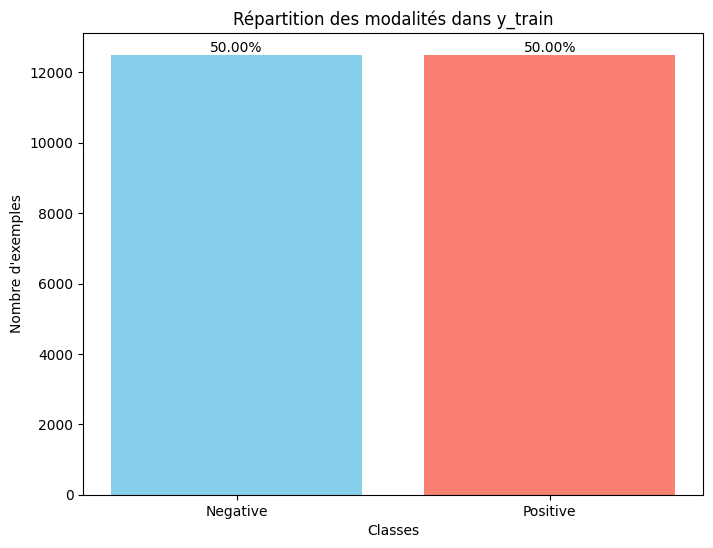

In [4]:
# Calcul de la répartition des classes
unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))

# Calcul des proportions pour chaque classe
total_samples = len(y_train)
proportions = [count / total_samples * 100 for count in counts]  # En pourcentage

# Création du diagramme en barres avec les proportions
plt.figure(figsize=(8, 6))
bars = plt.bar(class_distribution.keys(), class_distribution.values(), color=['skyblue', 'salmon'])
plt.xticks([0, 1], ["Negative", "Positive"])  # Remplacez les labels selon les classes
plt.xlabel("Classes")
plt.ylabel("Nombre d'exemples")
plt.title("Répartition des modalités dans y_train")

# Ajouter les proportions au-dessus de chaque barre
for bar, proportion in zip(bars, proportions):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{proportion:.2f}%",
        ha='center',
        va='bottom'
    )

plt.show()

### Transformation en texte humain des séquences de token pour qu'on puisse comprendre

In [19]:
word_index = imdb.get_word_index() #récupère un dictionnaire où chaque mot du vocabulaire IMDb est associé à un index unique

#décale tous les indices de 3 pour laisser de la place pour des tokens spéciaux.
word_index = {w:(i+3) for w,i in word_index.items()}

word_index.update({'[PAD]':0, '[CLS]':1, '[UNK]':2})
"""
[PAD] (padding, valeur 0) : utilisé pour remplir les séquences plus courtes, pour obtenir des séquences de même longueur.
[CLS] (classement, valeur 1) : token indiquant le début de chaque séquence, souvent utilisé pour des modèles comme BERT.
[UNK] (inconnu, valeur 2) : utilisé pour les mots qui n'apparaissent pas dans le vocabulaire.
"""
#dictionnaire inversé de word_index, où chaque index est associé à son mot correspondant. Cela permet de traduire une séquence de tokens en mots lisibles.
index_word = {index:word for word,index in word_index.items()}

# Fonction de traduction de critiques en texte lisible :
def dataset2text(review):
    return ' '.join([index_word.get(i, "?") for i in review[1:]])


print(dataset2text(x_train[12]))

i know the people and i did some of the animation and graphic design and the show is horrible they are rich little kids who don't have any talent and probably just begged nick to accept them alex has played the drums for one [UNK] i've played for 4 1 2 the movie is terrible and so is the show this is the craziest most mixed up comedy that even [UNK] funny i've ever seen it is so stupid it makes me want to barf it is just so crazy that nickelodeon would ever accept something like this and so dumb they are sooo stupid and weird i hate them and their show and think once nick realizes how stupid it is they will most hopefully take it off


In [20]:
#Fonction de chargement de modèle BERT
def load_model(distil):
  if distil:
      bert_model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")
      tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
  else:
      bert_model = TFBertModel.from_pretrained("bert-base-uncased")
      tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
  return bert_model, tokenizer

bert_model, tokenizer = load_model(distil)
bert_model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "tf_distil_bert_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
Total params: 66362880 (253.15 MB)
Trainable params: 66362880 (253.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Préprocessing des commentaires en utilisant le tokeniser de BERT, réalisation du padding et mise en forme du dataset pour les model BERT

In [21]:
#Cette fonction prend un sample (ici, une critique sous forme de texte) puis le convertit en tokens adaptés au modèle BERT.
def tokenize_sample(sample):
    return tokenizer(sample, truncation=True, max_length=review_len)

#Tokeniser un ensemble de données (dataset) en utilisant tous les cœurs CPU disponibles pour accélérer le processus.
def distributed_tokenize_dataset(dataset):
    dataset = list(dataset)
    #Pour faire des calcul en parallèle pour la tokenisation sur plusieurs coeurs
    with multiprocessing.Pool(multiprocessing.cpu_count()) as pool:
        tokenized_ds = list(tqdm(
            pool.imap(tokenize_sample, dataset),  # Tokenisation des textes bruts
            total=len(dataset)
        ))
    return tokenized_ds


# Assurez-vous que chaque élément est d'abord converti en texte brut
text_x_train = [dataset2text(sample) for sample in x_train]  # Conversion des tokens en texte brut
text_x_test = [dataset2text(sample) for sample in x_test]


tokenized_x_train = distributed_tokenize_dataset(text_x_train)
tokenized_x_test = distributed_tokenize_dataset(text_x_test)

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

In [22]:
#S'assure que toutes les séquences ont la même longueur en les remplissant (padding) à la longueur maximale.
data_collator = DataCollatorWithPadding(tokenizer, return_tensors="tf")
#Par exemple
data_collator(tokenized_x_train)

# transforme les données tokenisées en un format de dataset TensorFlow prêt pour l’entraînement du modèle
def make_dataset(x, y):
    collated = data_collator(x)#Faire le padding sur toutes les reviews

    """
    Chaque échantillon dans dataset est une tuple de trois éléments :
    - input_ids (séquence tokenisée),
    - attention_mask (indiquant les tokens réels vs padding) avec attention_mask un masque indiquant quelles positions correspondent aux tokens réels et lesquelles sont des tokens de padding (utile pour que le modèle ignore le padding). ,
    - y (label correspondant).
    """
    dataset = tf.data.Dataset.from_tensor_slices(
        (collated['input_ids'], collated['attention_mask'], y)
    )

    #Transformation du dataset en format adapté pour BERT qui attendent en entrée à la fois input_ids et attention_mask ensemble.
    """
    - Transforme chaque échantillon (input_ids, attention_mask, y) en ((input_ids, attention_mask), y).
    - shuffle(25000) : Mélange les données pour réduire la corrélation entre les échantillons consécutifs (valeur 25000 pour un mélange complet si c'est la taille du dataset).
    - batch(batch_size) : Regroupe les données en lots de taille batch_size (défini ailleurs comme 32).
    """
    transformed_dataset = (
        dataset.map(
            lambda x, y, z: ((x, y), z)
        ).shuffle(25000).batch(batch_size)
    )

    return transformed_dataset

train_ds = make_dataset(tokenized_x_train, y_train)
test_ds = make_dataset(tokenized_x_test, y_test)

for x, y in train_ds:
    print(x)
    break

(<tf.Tensor: shape=(40, 512), dtype=int32, numpy=
array([[ 101, 1996, 6358, ...,    0,    0,    0],
       [ 101, 2009, 2318, ...,    0,    0,    0],
       [ 101, 2023, 2143, ...,    0,    0,    0],
       ...,
       [ 101, 1045, 2387, ...,    0,    0,    0],
       [ 101, 7987, 7987, ...,    0,    0,    0],
       [ 101, 2023, 2733, ...,    0,    0,    0]], dtype=int32)>, <tf.Tensor: shape=(40, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>)


### Ajout de nouvelle tete au model BERT pour le finetune

In [23]:
class ClassificationModel(keras.Model):

    def __init__(self, bert_model):
        super(ClassificationModel, self).__init__()
        self.bert_model = bert_model
        """
        - pre_classifier : Une couche dense avec 768 unités et une activation relu, qui sert à transformer la sortie de BERT en une représentation adaptée pour la classification.
        - Une couche Dropout avec un taux de 0.1, utilisée pour éviter le surapprentissage en désactivant aléatoirement 10% des neurones lors de l'entraînement.
        - classifier : Une couche dense finale avec 2 unités (pour une classification binaire) et sans activation. La sortie brute de cette couche (logits) est interprétée comme les scores pour chaque classe.
        """
        self.pre_classifier = Dense(768, activation='relu')
        self.dropout_1 = Dropout(0.1)
       # Nouvelle couche dense supplémentaire avec 512 unités et activation relu
        self.additional_dense = Dense(512, activation='relu')
        self.dropout_2 = Dropout(0.1)
        self.classifier = Dense(2)

    # Methode
    def call(self, x):
      """
      - Passage par BERT produisant une sortie last_hidden_state.
      - Extraction du token [CLS] : x[:, 0]
      - pre_classifier : La couche dense avec relu affine la représentation [CLS].
      - dropout : La couche Dropout désactive une fraction des neurones pour renforcer la robustesse du modèle.
      - classifier : La dernière couche dense produit deux logits (non normalisés), un pour chaque classe
      """
      x = self.bert_model(x)
      x = x.last_hidden_state
      x = x[:, 0] # récupère la représentation du premier token [CLS], qui résume le sens général de la séquence (car BERT bidirectionnelle).
      x = self.pre_classifier(x)
      x = self.dropout_1(x)
      x = self.additional_dense(x)
      x = self.dropout_2(x)
      x = self.classifier(x)
      return x

    # Méthode de prédiction avec probabilités
    def predict(self, texts):
        """
        Prédit le sentiment d'une liste de phrases avec probabilités.

        Args:
        texts (list): Liste de phrases à analyser.

        Returns:
        list: Liste de tuples contenant le sentiment ('Positive' ou 'Negative') et la probabilité associée.
        """
        # Tokenisation des textes
        tokenized_texts = [tokenize_sample(text) for text in texts]
        collated = data_collator(tokenized_texts)

        # Convertir les données en tenseurs TensorFlow
        inputs = {
            'input_ids': tf.convert_to_tensor(collated['input_ids']),
            'attention_mask': tf.convert_to_tensor(collated['attention_mask'])
        }

        # Effectuer les prédictions
        logits = self(inputs)
        probs = tf.nn.softmax(logits, axis=-1)  # Calcule les probabilités pour chaque classe
        predictions = tf.argmax(probs, axis=-1)

        # Conversion en étiquettes lisibles et formatage des résultats avec probabilités
        results = [
            ("Positive" if pred == 1 else "Negative", float(probs[i][pred]))
            for i, pred in enumerate(predictions)
        ]

        return results


In [24]:
#Création du modèle
model = ClassificationModel(bert_model)

#Test
x = next(iter(train_ds))[0]
model(x)
model.summary()

Model: "classification_model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (40, 768)                   │         590,592 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (40, 768)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (40, 512)                   │         393,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (40, 512)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (40, 2)                     │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 985,346 (3.76 MB)

 Trainable params: 985,346 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(
    optimizer=Adam(1e-05),
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=[SparseCategoricalAccuracy(name='accuracy'), AUC(name='auc')]
)

history = model.fit(
    train_ds,
    validation_data=test_ds,  # évaluation sur la base de test
    epochs=epochs,
    verbose=fit_verbosity
)


Epoch 1/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 750s 1s/step - accuracy: 0.7189 - loss: 0.6094 - val_accuracy: 0.8276 - val_loss: 0.4239
Epoch 2/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 727s 1s/step - accuracy: 0.8380 - loss: 0.4014 - val_accuracy: 0.8436 - val_loss: 0.3636
Epoch 3/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 761s 1s/step - accuracy: 0.8517 - loss: 0.3526 - val_accuracy: 0.8505 - val_loss: 0.3458
Epoch 4/4
625/625 ━━━━━━━━━━━━━━━━━━━━ 726s 1s/step - accuracy: 0.8551 - loss: 0.3427 - val_accuracy: 0.8565 - val_loss: 0.3377


In [26]:
# Afficher les métriques de validation après l'entraînement
print("Validation Accuracy:", history.history['val_accuracy'])
print("Validation Loss:", history.history['val_loss'])


Validation Accuracy: [0.8276000022888184, 0.8436400294303894, 0.8504800200462341, 0.8565199971199036]
Validation Loss: [0.4239116311073303, 0.3635841906070709, 0.3457719385623932, 0.3376903235912323]


625/625 ━━━━━━━━━━━━━━━━━━━━ 364s 583ms/step - accuracy: 0.8598 - loss: 0.3316


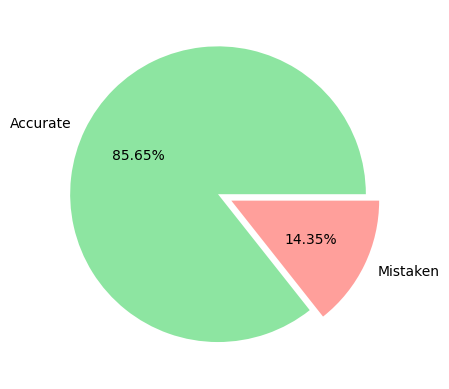

In [27]:
_, score = model.evaluate(test_ds)
colors = sns.color_palette('pastel')[2:]
accuracy_score = [score, 1 - score]
plt.pie(
    accuracy_score,
    labels=["Accurate", "Mistaken"],
    colors=colors,
    autopct=lambda val: f"{val:.2f}%",
    explode=(0.0, 0.1)
)
plt.show()

In [ ]:
# Obtenir les prédictions et étiquettes réelles
y_pred = []
y_true = []

for x, y in test_ds:
    predictions = model.predict(x)
    predicted_classes = np.argmax(predictions, axis=1)
    y_pred.extend(predicted_classes)
    y_true.extend(y.numpy())

# Matrice de confusion
plt.subplot(1, 2, 2)  # Deuxième moitié pour la matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.tight_layout()
plt.show()

In [28]:
# Exemples de phrases à tester
examples = [
    "This movie was absolutely fantastic! The acting was superb and the story was captivating.",
    "I didn't like this movie at all. It was boring and way too long.",
    "The plot was interesting, but the characters lacked depth.",
    "An amazing experience! One of the best movies I've ever seen.",
    "Terrible movie. I wouldn't recommend it to anyone."
]

# Utilisation de la nouvelle méthode `predict`
results = model.predict(examples)

# Affichage des résultats
for text, (sentiment, probability) in zip(examples, results):
    print(f"Text: {text} | Sentiment: {sentiment} | Probability: {probability:.2f}")

Text: This movie was absolutely fantastic! The acting was superb and the story was captivating. | Sentiment: Positive | Probability: 1.00
Text: I didn't like this movie at all. It was boring and way too long. | Sentiment: Negative | Probability: 0.88
Text: The plot was interesting, but the characters lacked depth. | Sentiment: Positive | Probability: 0.76
Text: An amazing experience! One of the best movies I've ever seen. | Sentiment: Positive | Probability: 0.99
Text: Terrible movie. I wouldn't recommend it to anyone. | Sentiment: Negative | Probability: 0.85
